# Session 1.2- Non-linear (Polynomial) Regression

In [ ]:
%pylab inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn
import IPython
import platform
from sklearn import preprocessing
print ('Python version:', platform.python_version())
print ('IPython version:', IPython.__version__)
print ('numpy version:', np.__version__)
print ('scikit-learn version:', sklearn.__version__)
print ('matplotlib version:', matplotlib.__version__)

## Generate a dataset using our coding skillz
First we will create a dataset.  This time we won't rely on sklearn since it does not appear to support basic non-linear regression problems.  It is easy to make our own, we will use a sine wave to make a curvy output.

In [ ]:
gen_data = False
if gen_data:
    # X_pure = np.arange(0,2*math.pi,0.01) # <-- "array-range" (start_val, stop_val, increment_value)
    # print(len(X_pure))
    X_pure = np.linspace(0,2*math.pi, 1000) # <-- just a nicer way to do it: (start_val, stop_val, num_increments)
    print(len(X_pure))
    true_fun = lambda x : 10*np.sin(x)

    np.random.seed(666)
    X = np.sort(random.choice(X_pure, size=100, replace=False))

    y_pure = np.sin(X_pure)
    y = true_fun(X) + np.random.randn(len(X)) # generate points with Gaussian noise
    plt.plot(X_pure, true_fun(X_pure), linestyle="-.")
else:
    #Alternative dataset, hours vs 1000s_of_bacteria, exponential growth y=Ae^(ax)
    X_pure = None
    data = [(2.5, 10.07),
    (2.8, 11.07),
    (5.4, 14.59),
    (6.5, 20.70),
    (9.2, 27.94),
    (9.5, 31.50),
    (11.0, 38.04),
    (13.3, 49.90),
    (14.6, 60.72),
    (16.4, 75.57)]
    X = np.array([tup[0] for tup in data]).reshape(-1,1)
    y = np.array([tup[1] for tup in data]).ravel()
    
features_names = ["The Feature"]
plt.ylabel("y")
plt.xlabel(features_names[0])

X = X.reshape(-1,1) # need to convert X from a list to a list of single-feature-lists [[x1],[x2],[x3] ...]
print(X.shape, y.shape)
plt.scatter(X, y)

## Partition the dataset
As before, manually partition the dataset

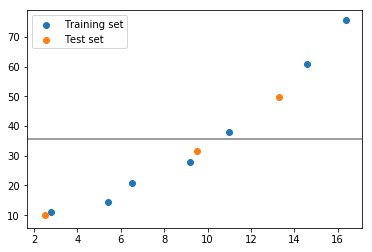

In [11]:
n = len(X)

test_split = 0.25
test_n = int(test_split*n)

all_indices = list(np.arange(n))
numpy.random.seed(666)
test_indices = numpy.random.choice(all_indices, size=test_n, replace=False)
train_indices = list(set(all_indices) - set(test_indices))

X_train  = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

# convenience class to do the above...
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=666)

if X_pure is not None:
    plt.plot(X_pure, true_fun(X_pure), linestyle="--", label="True")
plt.scatter(X_train, y_train, label="Training set")
plt.scatter(X_test, y_test, label="Test set") #it's sneaky to look at your test data!
plt.legend() # gets its labels from the plot and scatter "label" params
plt.axhline(np.mean(y_train), color="grey")
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

## Create a training wrapper
This routine trains an estimator and carries out k-fold cross-validation to get a "typical" score for performance.

We specify a "refit" parameter which is False by default.  The routine checks if the estimator is already fitted and if so, it does not train again.  It can be overridden if training is desired (set the param to True at method invocation).

If the number of folds is set too low (i.e. <2) then the routine assumes you don't want cross validation at all, and will just score the estimator on the _X and _y values passed in.

In [ ]:
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import mean_squared_error
def train_and_evaluate(_reg, _X, _y, n_folds=0, refit=False):
    # Estimator objects can be fitted or unfitted.  If the user wants to force a retraining, then we do not need to check the status of the estimator
    # PART 1: Check whether we need to refit
    if refit==True:
        do_train=True
    else:
        try:
            check_is_fitted(_reg)
            print("Estimator is already fitted: will assume you are using the test set and not train it again!")
            do_train=False
        except:
            do_train=True

    # PART 2: If we must refit, do the training here
    if do_train:
        _reg.fit(_X, _y)
        print ('Score on training set: {:.2f}'.format(_reg.score(_X, _y)))

    # PART 3: test for goodness of fit
    if n_folds >= 2: # we need at least 2 folds to do cross validation
        cv = sklearn.model_selection.KFold(n_splits= n_folds, shuffle=True, random_state=666)
        scores = sklearn.model_selection.cross_val_score(_reg, _X, _y, cv=cv, scoring="explained_variance")
        av_score = np.mean(scores)
        print ('Average score using {}-fold crossvalidation:{:.2f}'.format(n_folds,av_score))
    else: #otherwise just do a normal scoring
        av_score = sklearn.metrics.explained_variance_score(_reg.predict(_X),_y)
        print("Plain (non-CV) score on X vs y:{:.2f}".format(av_score))
    return _reg, av_score

## Create a new F-test routine
Define the F-test function, slighty funkier than before because we need to deal with models of varying complexity (i.e. different numbers of model parameters)

This routine in particular is modelled on [this specification](https://sites.duke.edu/bossbackup/files/2013/02/FTestTutorial.pdf).

In [ ]:
import scipy

def f_test(residuals_1, residuals_2, nparams_1=2, nparams_2=2, alpha=0.95):
    SSR1 = numpy.sum(numpy.power(residuals_1,2))
    SSR2 = numpy.sum(numpy.power(residuals_2,2))
    print(SSR1, SSR2)
    
    dfn = len(residuals_1)-nparams_1 #define degrees of freedom numerator 
    dfd = len(residuals_2)-nparams_2 #define degrees of freedom denominator 
    print("dfs:", dfn, dfd)

    if nparams_1 == nparams_2:
        f = (SSR1/SSR2)
    else:
        if nparams_1 < nparams_2: # model 1 must be simpler for this formula
            f = ((SSR1/SSR2)/(dfn-dfd)) / (SSR2/dfd)
        else:
            raise Exception("Model params out of order: simpler model must come first")
    
    p = 1-sp.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    # p is smaller when f is smaller
    print("f is",f)
    print("p is",p)
    
    # slightly different way of processing results if n_params is the same for both models
    if nparams_1 != nparams_2:
    #     In this case a p-value less than α indicates that the more complex model (denominator of F-statistic)
    #     fits the data significantly better than the simpler model.        
        if p < alpha: # if the probability of the null hypothesis is < the critical value
            print("Model 2 is better")
        else:
            print("F-test is inconclusive (cannot reject H0)")    
    else:
    #     If the p-value is large (greater than α) then the first model is statistically better than the second.
    #     If the p-value is small (less than 1-α) then the second model is statistically better than the first.
        if p > alpha:
            print("Model 1 is better")
        elif p < (1-alpha):
            print("Model 2 is better")
        else:
            print("F-test is inconclusive (cannot reject H0)")
    
    return f, p

## Non-linear (polynomial) regression
This time we will use a transformer object called PolynomialFeatures to bring in more complex non-linear features to the dataset.  The regression model remains linear, it is the features we are turning polynomial..

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

polyfeats = PolynomialFeatures(degree=2)
X_f = polyfeats.fit_transform(X_train)
X_f_test = polyfeats.transform(X_test)

est2 = LinearRegression() # common or garden OLS linear regression model .. the non-linearities are in the features
est2.fit(X_f, y_train)

for name, this_est in [("Quadratic reg.", est2), ]:
    print(name.upper())
    for dataset_name, this_X, this_y in [("Training set", X_f, y_train), ("Test set", X_f_test, y_test)]:
        print(dataset_name)
#         print("R2 is", this_est.score(this_X, this_y))
        # Don't use R2! https://statisticsbyjim.com/regression/r-squared-invalid-nonlinear-regression/
        this_y_hats = this_est.predict(this_X)
#         av_score = sklearn.metrics.explained_variance_score(this_est.predict(this_X), this_y)
#         print("Explained variance is {}".format(av_score))
        print("MAE is", mean_absolute_error(this_y, this_y_hats))
        print("MSE is", mean_squared_error(this_y, this_y_hats))
        print("RMSE is", numpy.sqrt(mean_squared_error(this_y, this_y_hats)))
        print("---")

In [ ]:
def poly_features_param_search(_est, _X,_y, _X_test, _y_test):
    #first plot the real dataset
    plt.figure(figsize=(10,10))
    plt.scatter(_X, _y)
    plt.scatter(_X_test, _y_test)
    
    # next prep some places to store results
    best = (None, None, -math.inf, -math.inf)
    y_hat_list = []
    
    # loop across a bunch of different polynomial degrees for increasingly complex curve fit
    for deg in [1,2,3,7]:
        for inter_only in [False, ]: #can switch interaction-only features on here if we ever want to (really for multivariate data)
            print(">>>",deg)
            polyfeat = PolynomialFeatures(degree=deg, interaction_only=inter_only)
            X_f = polyfeat.fit_transform(_X)
            _est, sc_tr = train_and_evaluate(_est, X_f, _y, 5, refit=True) # fit and cross val the estimator

            y_hats = _est.predict(X_f)
            y_hat_list.append((deg,y_hats)) #keep these for later!

            # the next few lines are just to draw the regression line on the graph
            xs = np.linspace(X_train.min()-1, X_train.max()+1,30).reshape(-1,1) 
            xs_poly = polyfeat.transform(xs)
            y_hats_for_curve = _est.predict(xs_poly)
            plt.ylim(min(_y)-1, max(_y)+1)
            plt.plot(xs, y_hats_for_curve, label=str(deg)) # add the regression line for this run
            
            if sc_tr > best[2]: # if your cross-val'd score is best so far...
                print("*** NEW BEST")
                X_f_test = polyfeat.transform(_X_test)
                _est, sc_tt = train_and_evaluate(_est, X_f_test, _y_test, 0, refit=False) # get test data score
                best = (deg, inter_only, sc_tr, sc_tt) # stash it all in a tuple
    print(best)
    plt.legend()
    plt.show()
    return best, y_hat_list

best, y_hat_list = poly_features_param_search(LinearRegression(), X_train, y_train, X_test, y_test)

In [ ]:
get_residuals = lambda yh,y : (yh-y) # lambda expressions are a way of defining simple functions
# def get_residuals(yh,y): return (yh-y) # same as above
previous_residuals = None
prev_deg = None
f_test_results = []

flat_ys = np.ones_like(y_train) * np.mean(y_train)
if y_hat_list[0][0] != 0: # this stops us adding loads of mean-y estimators whenever we rerun this cell :)
    y_hat_list.insert(0, (0, get_residuals(flat_ys, y_train)))

for deg, y_hats in y_hat_list:
    print(">>>{}".format(deg))
    residuals = get_residuals(y_hats, y_train)
#     print(residuals)
    plt.scatter(X_train, residuals)
    plt.axhline(0)
    plt.show()

    plt.hist(residuals)
    plt.show()
    
    if previous_residuals is not None:
        match_id = "{} vs {}".format(deg, prev_deg)
        print(match_id)
        f,p = f_test(previous_residuals, residuals, prev_deg, deg)
        print(p)
        f_test_results.append((match_id, p))
    previous_residuals = residuals
    prev_deg = deg
    
print("---")
for i,p in f_test_results:
    print(i,p, "Prob Different" if p<0.05 else "Cannot reject H0")


## Summary
- We generated a dataset based on a sine wave (or used bacterial growth data), and partitioned train/test sets
- We implemented non-linear regression at the feature level using the PolynomialFeatures transformer
- We set up a method to train and cross-validate our models
- We did a parameter search across various degrees of polynomial to find a better fit
- We used the F-test to decide which of our fits were significant improvements compared to degree (n-1)